In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math

from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [2]:
from matplotlib import rcParams
rcParams["figure.figsize"] = (12, 6)
rcParams["lines.linewidth"] = 3
rcParams["xtick.labelsize"] = "x-large"
rcParams["ytick.labelsize"] = "x-large"

In [3]:
data1 = pd.read_csv("train.csv")
data1.shape

(891, 12)

In [4]:
data1.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
578,579,0,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,NaN,C
527,528,0,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S
835,836,1,1,"Compton, Miss. Sara Rebecca",female,39.0,1,1,PC 17756,83.1583,E49,C
805,806,0,3,"Johansson, Mr. Karl Johan",male,31.0,0,0,347063,7.7750,NaN,S


In [5]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
data1.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
data1.dropna(subset=["Embarked"], inplace=True)

In [8]:
data2 = data1.drop(columns=["Cabin", "Ticket"])

In [9]:
data2["Age"] = data2["Age"].fillna(data2["Age"].median())

In [10]:
data2.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [11]:
print(data2.duplicated().sum())

0


In [12]:
target = "Survived"
id_col = "PassengerId"

cat = ["Sex", "Embarked"]
num = ["Pclass", "Age", "SibSp", "Parch", "Fare"]

In [13]:
data2[cat].describe()

,Sex,Embarked
count,889,889
unique,2,3
top,male,S
freq,577,644


In [14]:
data2[num].describe()

,Pclass,Age,SibSp,Parch,Fare
count,889.000000,889.000000,889.000000,889.000000,889.000000
mean,2.311586,29.315152,0.524184,0.382452,32.096681
std,0.834700,12.984932,1.103705,0.806761,49.697504
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.895800
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,35.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [15]:
for col in cat:
    print(f"value count column {col} :")
    print(data2[col].value_counts())
    print()

value count column Sex :
Sex
male      577
female    312
Name: count, dtype: int64

value count column Embarked :
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64



## UNIVARIATE ANALYSIS

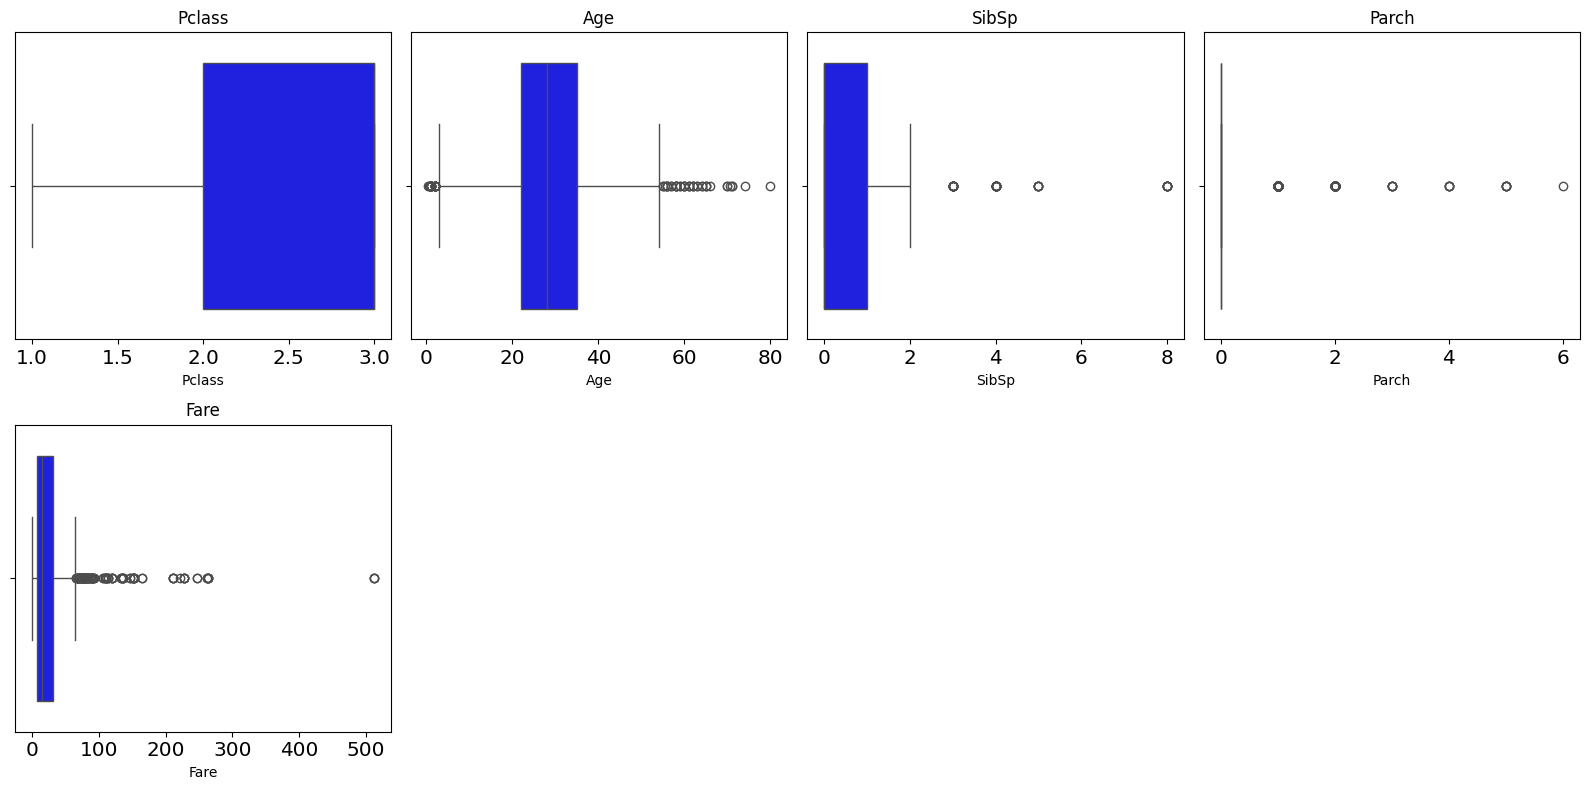

In [16]:
plt.figure(figsize=(16, 8))

for i, col in enumerate(num):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x=data2[col], color="blue")
    plt.title(col)

plt.tight_layout()
plt.show()

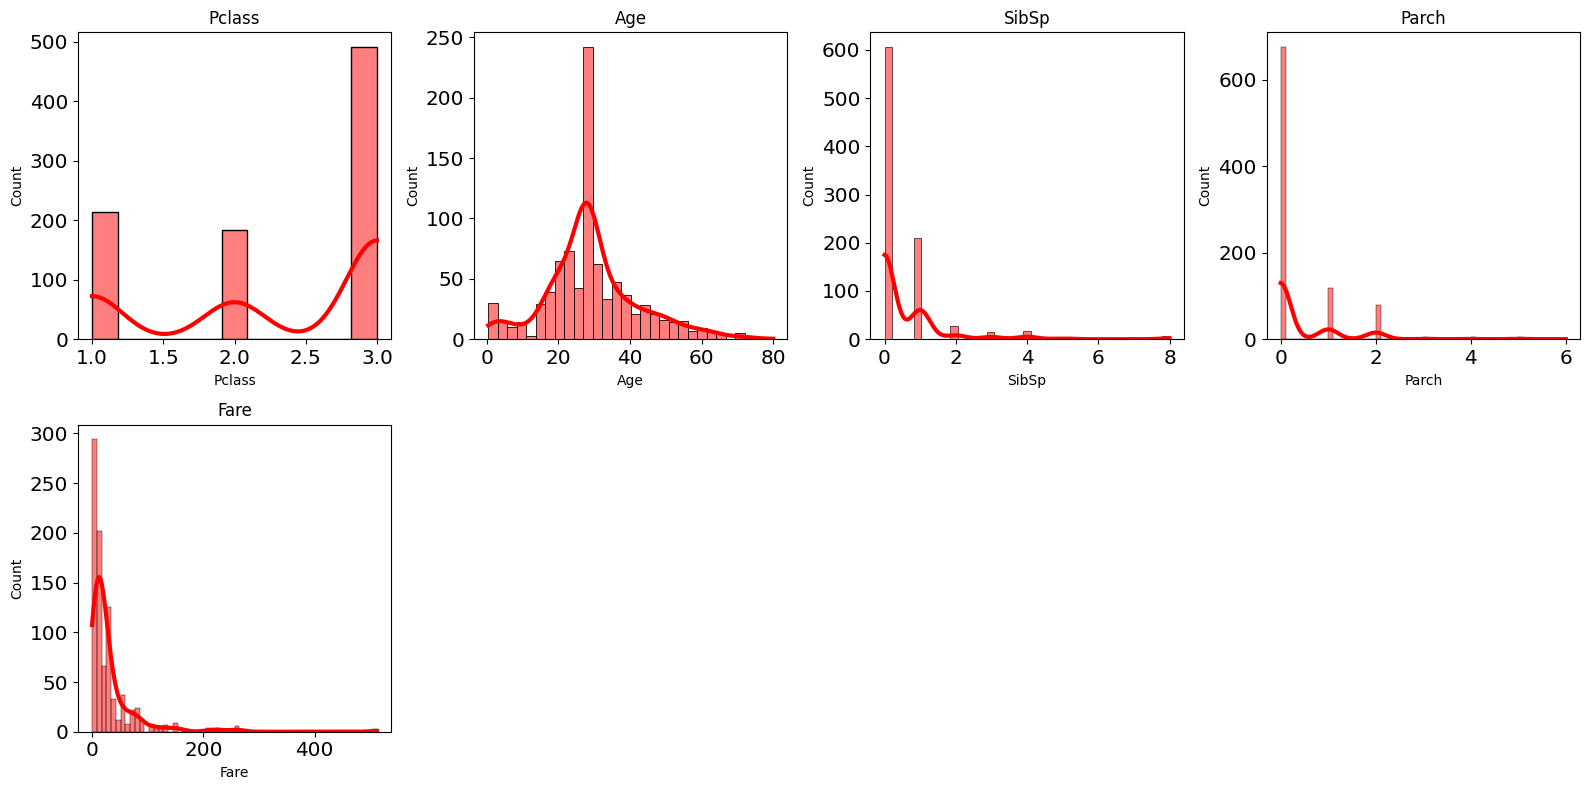

In [17]:
plt.figure(figsize=(16, 8))

for i, col in enumerate(num):
    plt.subplot(2, 4, i + 1)
    sns.histplot(data=data2, x=col, kde=True, color="red")
    plt.title(col)

plt.tight_layout()
plt.show()

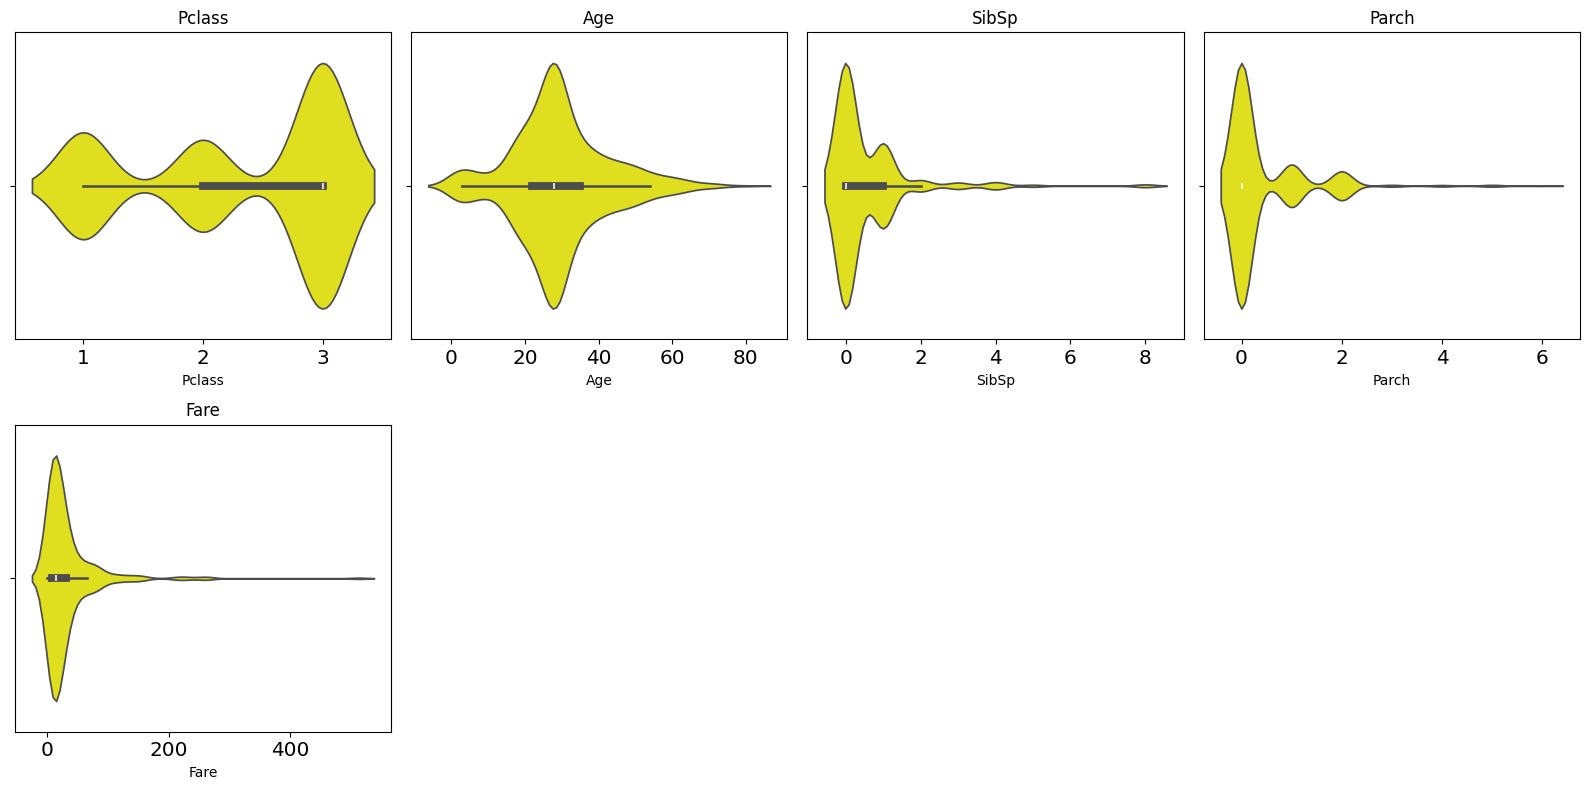

In [18]:
plt.figure(figsize=(16, 8))

for i, col in enumerate(num):
    plt.subplot(2, 4, i + 1)
    sns.violinplot(x=data2[col], color="yellow")
    plt.title(col)

plt.tight_layout()
plt.show()

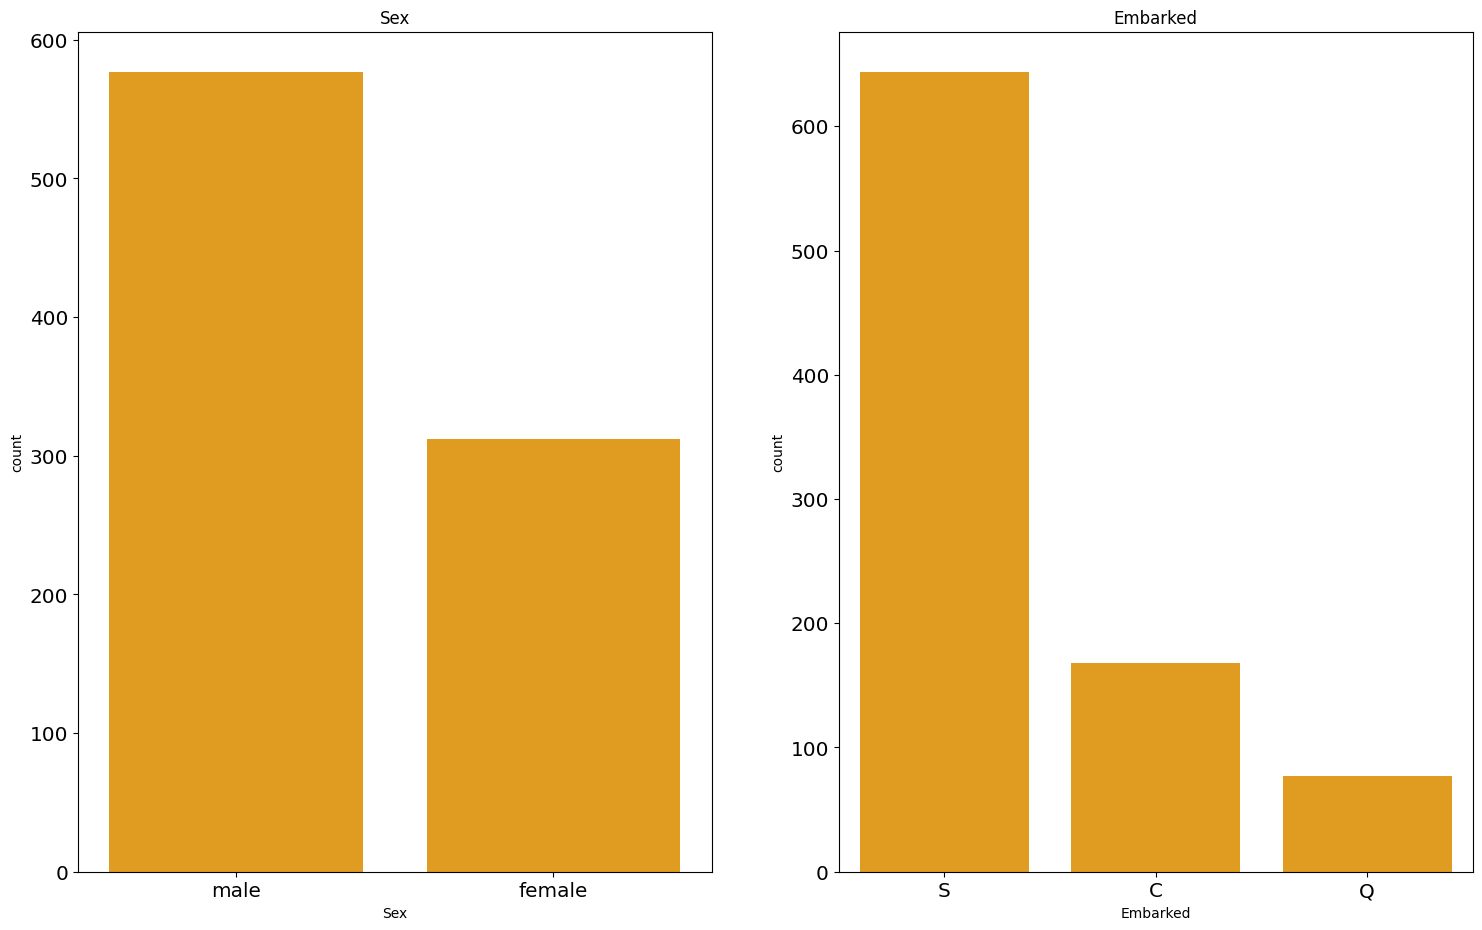

In [19]:
plt.figure(figsize=(18, 24))

for i, col in enumerate(cat):
    plt.subplot(2, 2, i + 1)
    
    sns.countplot(
        data=data2,
        x=col,
        color="orange"
    )
    
    plt.title(col)
    # plt.xticks(rotation=45)

# plt.tight_layout()
plt.show()

In [20]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Fare         889 non-null    float64
 9   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 76.4+ KB


In [21]:
data2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


## Bivariate Analysis

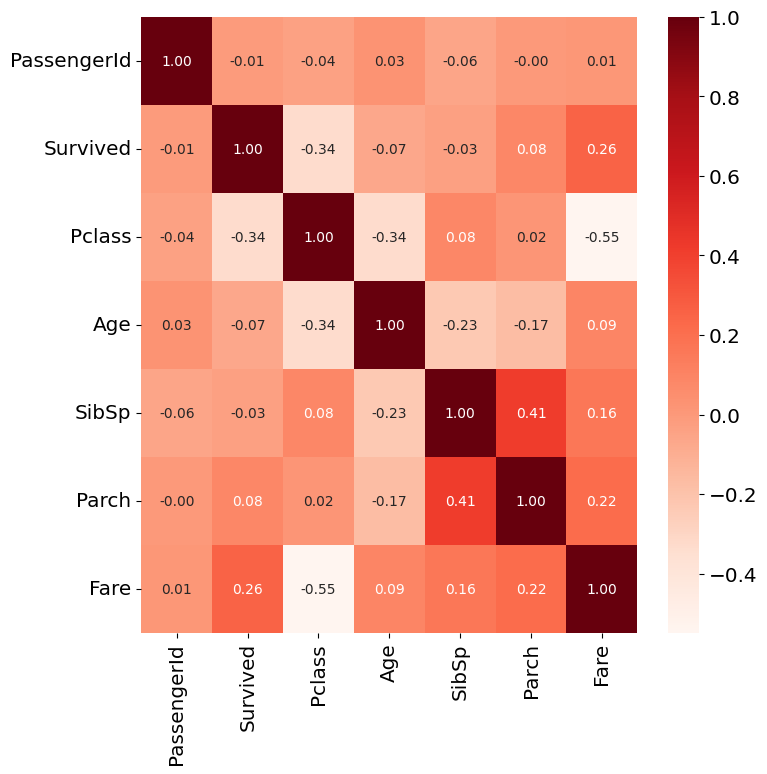

In [22]:
plt.figure(figsize=(8, 8))
corr_matrix = data2.select_dtypes(include="number").corr()

sns.heatmap(
    corr_matrix,
    cmap="Reds",
    annot=True,
    fmt=".2f"
)

plt.show()

<Figure size 1000x1000 with 0 Axes>

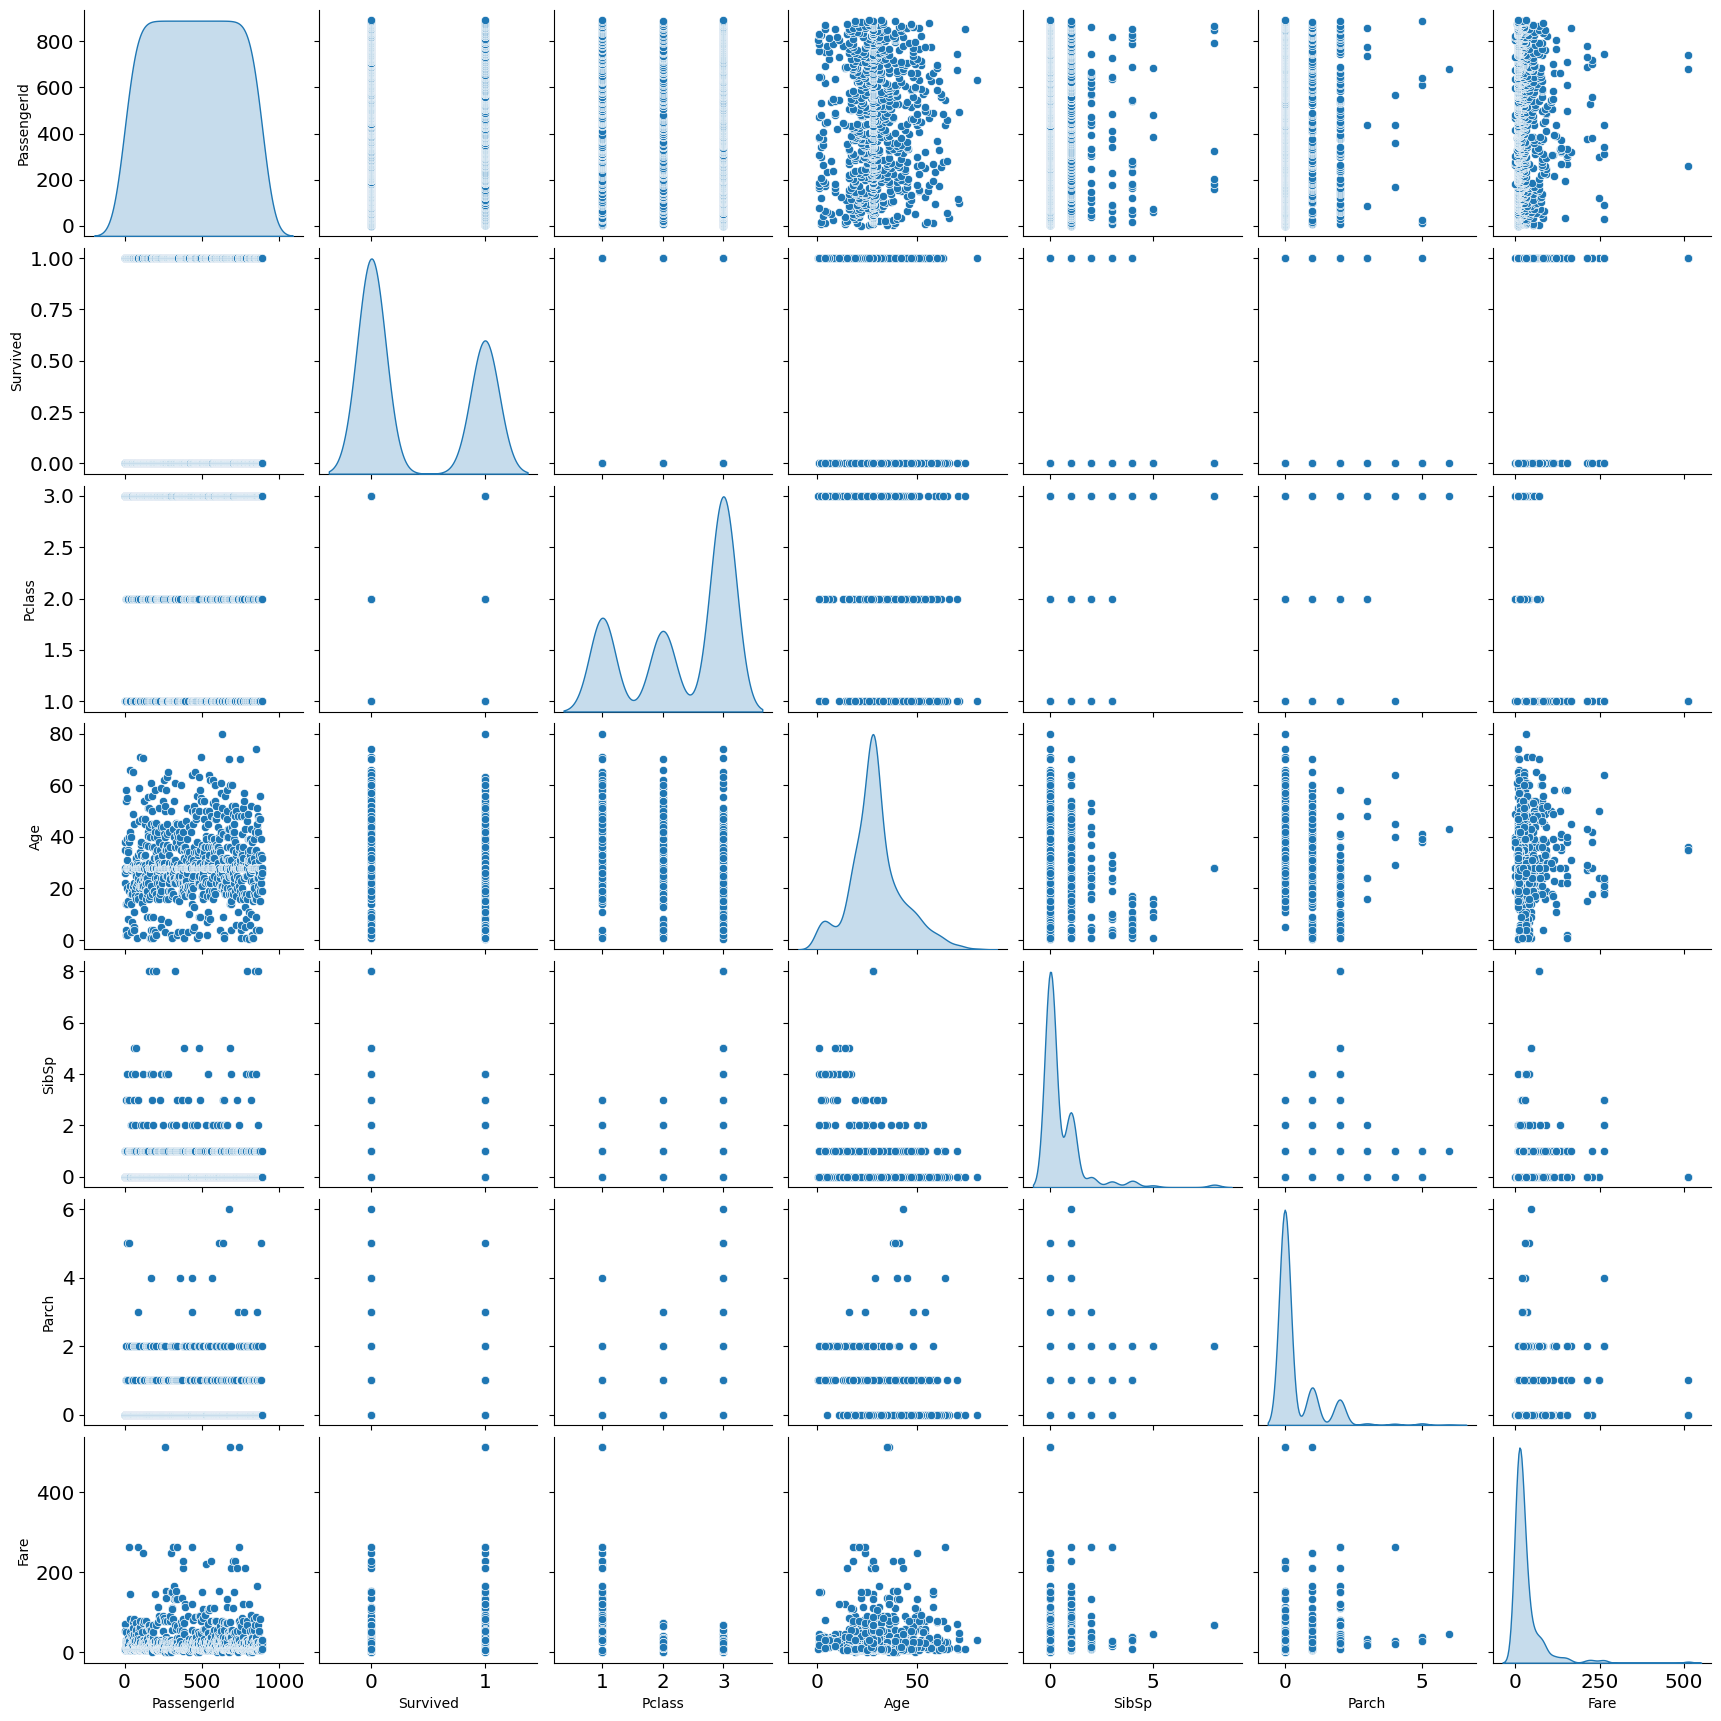

In [23]:
plt.figure(figsize=(10, 10))
sns.pairplot(
    data2,
    diag_kind="kde"
)
plt.show()

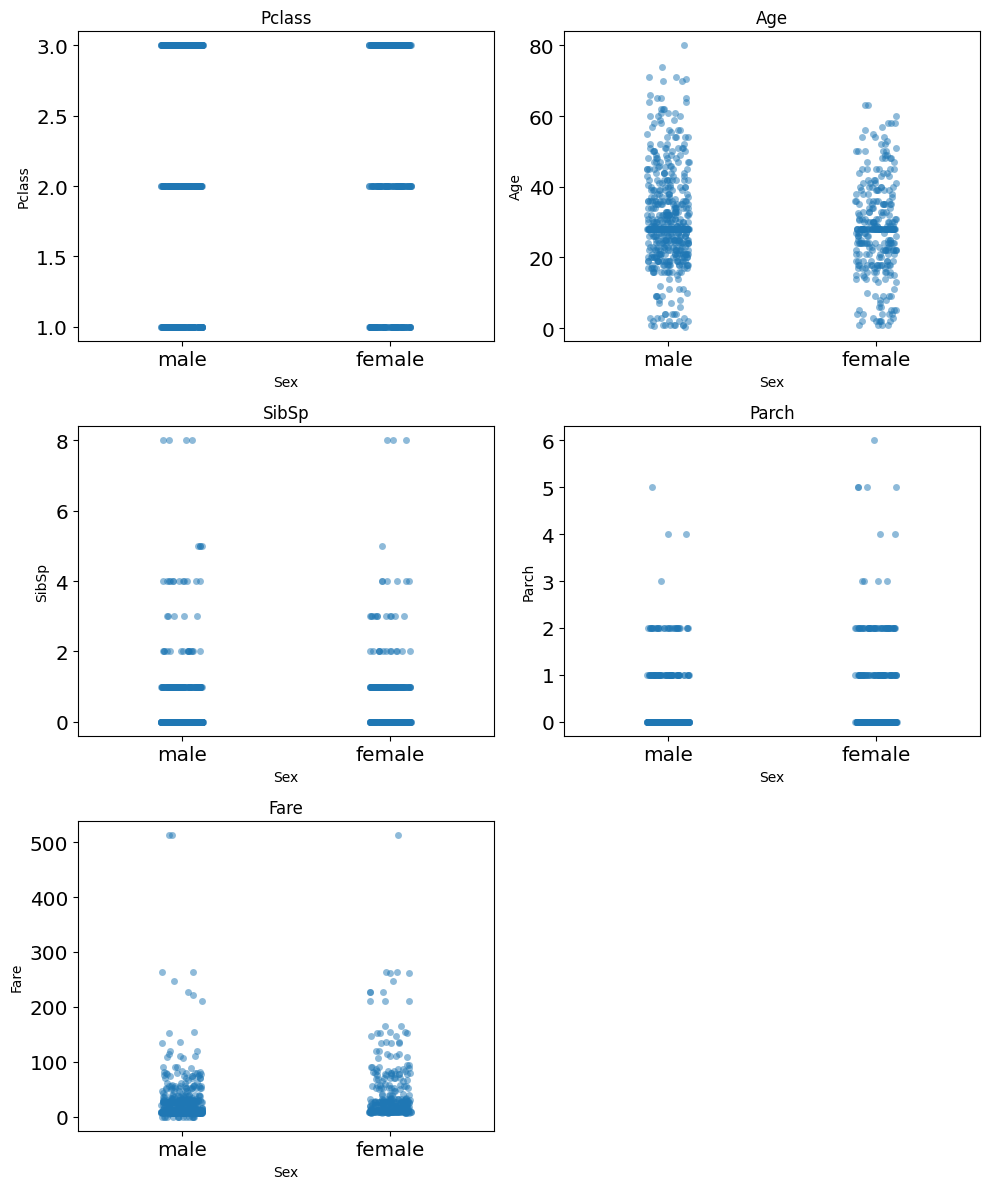

In [24]:
n_cols = 2
n_rows = math.ceil(len(num) / n_cols)

plt.figure(figsize=(10, 4 * n_rows))

for i, col in enumerate(num):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.stripplot(
        data=data2,
        x="Sex",
        y=col,
        jitter=True,
        alpha=0.5
    )
    plt.title(col)

plt.tight_layout()
plt.show()

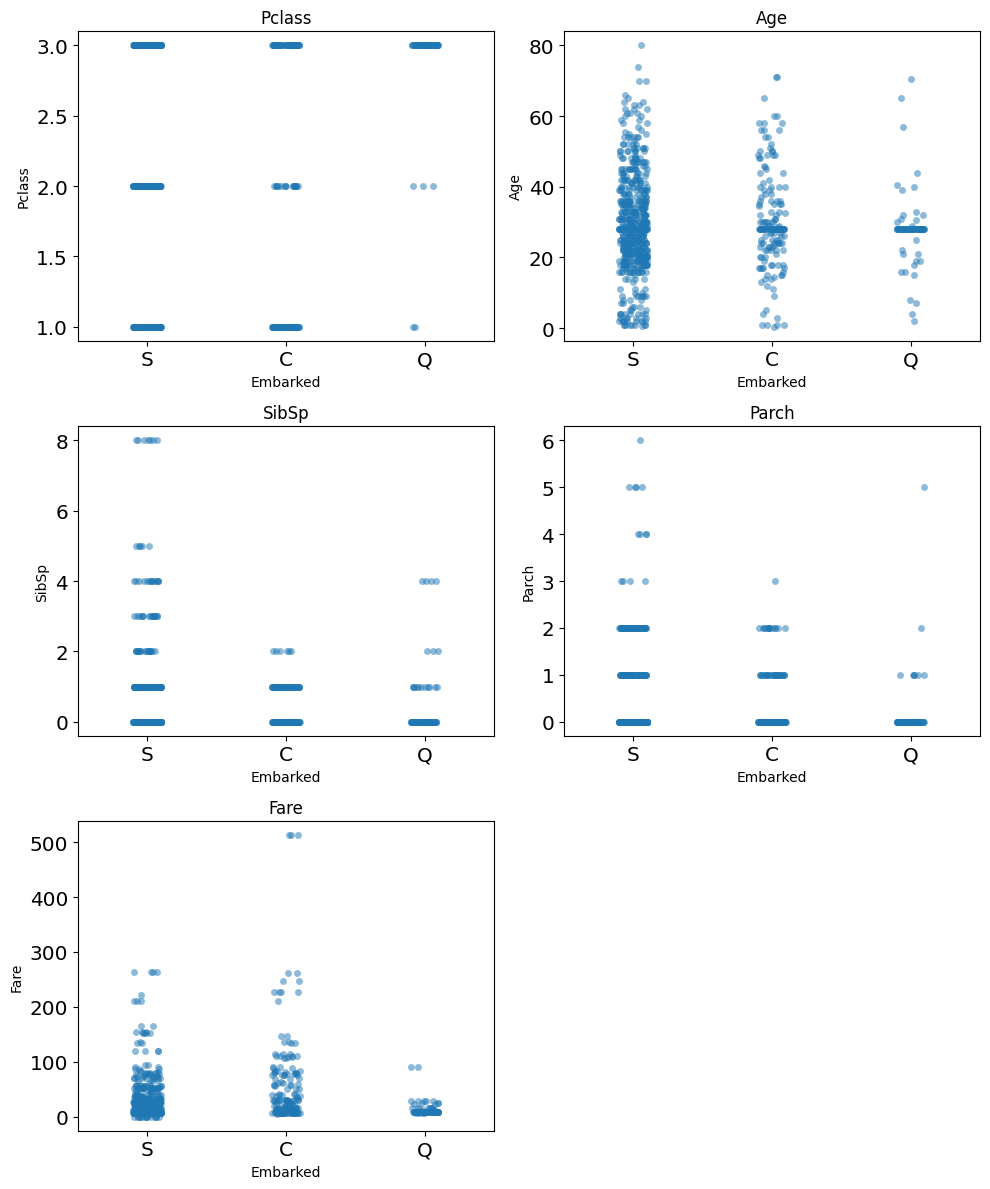

In [25]:
n_cols = 2
n_rows = math.ceil(len(num) / n_cols)

plt.figure(figsize=(10, 4 * n_rows))

for i, col in enumerate(num):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.stripplot(
        data=data2,
        x="Embarked",
        y=col,
        jitter=True,
        alpha=0.5
    )
    plt.title(col)

plt.tight_layout()
plt.show()

In [26]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Fare         889 non-null    float64
 9   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 76.4+ KB


In [27]:
data2.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [28]:
df_clean = data2

df_clean.to_csv("titanic_survived_clean.csv", index=False)
print("Saved: titanic_survived_clean.csv")

Saved: titanic_survived_clean.csv


## Machine Learning Training

In [29]:
data_clean = data2.copy()

X = data_clean[num + cat]
y = data_clean[target].astype(int)

X = pd.get_dummies(X, columns=cat, drop_first=False)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=75)

In [31]:
model = XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.8033707865168539

## Inference 

In [32]:
test_df = pd.read_csv("test.csv")

In [33]:
test_clean = test_df.drop(columns=["Cabin", "Ticket"], errors="ignore").copy()

In [34]:
age_median = data_clean["Age"].median()
emb_mode = data_clean["Embarked"].mode()[0]
fare_median = data_clean["Fare"].median()

test_clean["Age"] = test_clean["Age"].fillna(age_median)
test_clean["Embarked"] = test_clean["Embarked"].fillna(emb_mode)
test_clean["Fare"] = test_clean["Fare"].fillna(fare_median)

In [35]:
test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Fare         418 non-null    float64
 8   Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 29.5+ KB


In [36]:
X_test = test_clean[num + cat].copy()
X_test = pd.get_dummies(X_test, columns=cat, drop_first=False)

In [38]:
X_test = X_test.reindex(columns=X.columns, fill_value=0)

In [39]:
test_preds = model.predict(X_test).astype(int)

In [40]:
submission = pd.DataFrame({
    id_col: test_df[id_col],
    target: test_preds
})

submission.to_csv("titanic_infer.csv", index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
